# Datashader Workshop

`Datashader` is a graphics pipeline system for visualizing large amounts of data. It breaks the creation of images into 3 steps:
1. Projection: Each record is projected into zero or more bins.
2. Aggregation: Reductions are computed for each bin, compressing the datset into a smaller aggregate one.
3. Transformation: Aggregates are further processed to create an image.

The `Datashader` module from Continuum Analytics came out of funding from DARPA’s XDATA program, a research effort to develop new computational techniques and open-source software tools for processing and analyzing big data.

Import Python modules.  
- Standard Python modules.
- `Bokeh` modules.
- `Datashader` modules.

In [1]:
%%time
import pandas as pd
import numpy as np

from bokeh.plotting import output_notebook, figure, show
from bokeh.models import WMTSTileSource

import datashader as ds
import datashader.transfer_functions as tf
from datashader.bokeh_ext import InteractiveImage

output_notebook()
%matplotlib inline

Loading BokehJS ...

CPU times: user 175 ms, sys: 37.1 ms, total: 212 ms
Wall time: 241 ms


In [2]:
pd.options.display.max_rows = 10

## Read Data

In [3]:
%time df = pd.read_csv('bsm41993-41994.csv')
df = df.iloc[::10,:]
df = df.query('TripStart == 41994')
df.head()

CPU times: user 44.7 s, sys: 9.66 s, total: 54.3 s
Wall time: 57.6 s


,RxDevice,FileId,Gentime,Latitude,Longitude,Speed,TripStart
22715930,1063,8475488,346251981946550,42.314659,-83.650154,21.700001,41994
22715940,1063,8475488,346251982946313,42.314487,-83.650276,21.559999,41994
22715950,1063,8475488,346251983946407,42.314316,-83.650391,21.360001,41994
22715960,1063,8475488,346251984946392,42.314144,-83.650513,21.120001,41994
22715970,1063,8475488,346251985946388,42.313976,-83.650627,21.000000,41994


In [4]:
df.shape

(1778698, 7)

## Some Data Wrangling

Function to convert _latitude_, _longitude_ degree coordinates to meters in web mercator projection.

In [5]:
def latlng_to_meters(df, lat_name, lng_name):
    origin_shift = 2 * np.pi * 6378137 / 2.0
    mx = df[lng_name] * origin_shift / 180.0
    my = np.log(np.tan((90 + df[lat_name]) * np.pi / 360.0)) / (np.pi / 180.0)
    my = my * origin_shift / 180.0
    mx = mx.apply(lambda x: np.around(x,0))
    my = my.apply(lambda y: np.around(y,0))
    df.loc[:,lng_name] = mx.astype(int)
    df.loc[:,lat_name] = my.astype(int)
    return df

Call `latlng_to_meters` conversion function.  
Convert _Speed_ to mph.  
Make _Gentime_ as small as possible.  
Rename columns.  
Discard data containing speeds above 100 _mph_.  

In [6]:
df = latlng_to_meters(df,"Latitude","Longitude")
df['Speed'] = df['Speed']*2.23694
df['Gentime'] = df['Gentime'] - df['Gentime'].min()
df.rename(columns={'Latitude':'y','Longitude':'x','Speed':'mph'}, inplace=True)
df = df.query('mph < 100')

In [7]:
df

,RxDevice,FileId,Gentime,y,x,mph,TripStart
22715930,1063,8475488,47049387386,5208231,-9311893,48.541600,41994
22715940,1063,8475488,47050387149,5208205,-9311906,48.228424,41994
22715950,1063,8475488,47051387243,5208179,-9311919,47.781041,41994
22715960,1063,8475488,47052387228,5208153,-9311933,47.244175,41994
22715970,1063,8475488,47053387224,5208128,-9311945,46.975740,41994
...,...,...,...,...,...,...,...
40502860,11628,9182479,79322023255,5224340,-9286249,10.200446,41994
40502870,11628,9182479,79323029262,5224335,-9286254,12.974252,41994
40502880,11628,9182479,79324027579,5224327,-9286256,14.674326,41994
40502890,11628,9182479,79325030381,5224317,-9286258,16.687572,41994


## Standard Bokeh Plot

Manually set xy range of figure

In [8]:
if False:
    xrange = [x-1000 for x in (-9324094,-9314310)]
    yrange = [y+1500 for y in (5195271, 5205055)]
else:
    xrange = [x+2000 for x in (-9333878,-9314310)]
    yrange = [y+6000 for y in (5185487, 5205055)]

Define our basic `Bokeh` plot configuration. Set interactive tools, xy range, plot width and height.  
Set axis and grid lines to off.  
Define border margins.

In [9]:
width = 400
height = 400
def base_plot():
    p = figure(tools='pan, box_zoom, reset', plot_width=width, plot_height=height,
              x_range=xrange, y_range=yrange, outline_line_color=None)
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.min_border_bottom = 0
    p.min_border_top = 0
    p.min_border_left = 0
    p.min_border_right = 0
    return p

Draw `Bokeh` figure using `circle` markers.

In [10]:
options = dict(line_color=None, fill_color='blue', size=3, alpha=0.1)
samples = df.sample(n=10000, random_state=20160)
s = base_plot()
s.circle(samples['x'], samples["y"], **options)
show(s)

## Datashader Plot

Create a canvas representing the space for binning data records.  
**Projection and Aggregation Step**: Create points centered at x and y with the z-value being the aggregate summary (count in this case).  
**Transformation Step**: Converts the 2D DataArray (pts) to an image interpolating between the low and high color linearly.  
Display the image

In [11]:
canvas = ds.Canvas(plot_width=width, plot_height=height, 
                   x_range=xrange, y_range=yrange, 
                   x_axis_type='linear', y_axis_type='linear')
pts = canvas.points(df, 'x', 'y', agg=ds.count('Gentime'))

Color by Gentime Counts in Each Grid

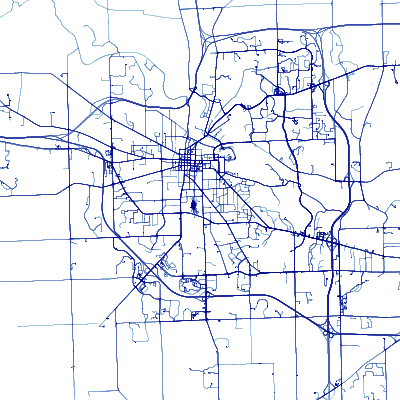

In [12]:
tf.Images(tf.shade(pts, name="Color by Gentime Counts in Each Grid"))

Color by Max Speed in Each Grid

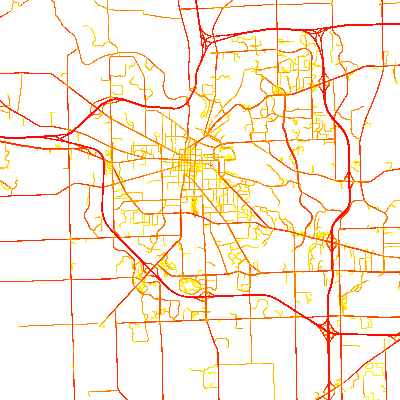

In [13]:
pts = canvas.points(df, 'x', 'y', ds.max('mph'))
tf.Images(tf.shade(pts, cmap=['yellow','red'],name="Color by Max Speed in Each Grid"))

### Plotting Multiple Layers

You can combine images together, layering images onto one another using the transfer function `stack` method.

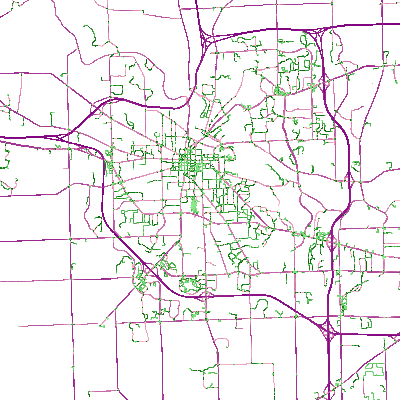

In [14]:
def merge_images(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    pts = cvs.points(df, 'x', 'y', ds.mean('mph'))
    low = tf.shade(pts.where(pts<25), cmap=["lightgreen", 'darkgreen'])
    high = tf.shade(pts.where(pts>25), cmap=["pink", 'purple'] )
    return tf.stack(low,high) # order of layers

merge_images(xrange,yrange,width,height)

### Datashader Interactive Plot

Datashader combined with the Bokeh interactive plot. Allows you to pan and zoom in on the image.  
1. For a single image and it will just zoom in on the image
2. More multiple images, it will re-draw a new image

In [15]:
def create_image(xrange, yrange, w=width, h=height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=xrange, y_range=yrange)
    agg = cvs.points(df, 'x', 'y', ds.mean('mph'))
    img = tf.shade(agg, cmap=["yellow",'darkblue'])
    return img

p = base_plot()
InteractiveImage(p, create_image)

In [16]:
p2 = base_plot()
InteractiveImage(p2, merge_images)

### Add Background Web Tiles to Geospatial Data

Choose a web tile provider using the `WMTSTileSource` class and `add_tile` method. You can choose any provider like OpenStreetMaps, Esri, Mapbox, etc. Here we use the STAMEN watercolor web tiles.

In [17]:
tile_options = dict()
tile_options['url'] = 'http://tile.stamen.com/watercolor/{z}/{x}/{y}.png'
tile_source = WMTSTileSource(**tile_options)

p = base_plot()
p.add_tile(tile_source)
InteractiveImage(p, merge_images)

## References

References are bare bones since this is a brand new module (version 0.1.0).  
http://datashader.readthedocs.org/en/latest/  
https://media.readthedocs.org/pdf/datashader/latest/datashader.pdf

## Software Version for Creating this Jupyter Notebook

In [ ]:
# you only need to do the following line once on your machine
#%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information pandas, numpy, bokeh, datashader